In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import time

# Device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1. Load and normalize MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor()
])

full_train = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_data = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Split into train and validation
train_size = int(0.8 * len(full_train))
val_size = len(full_train) - train_size
train_data, val_data = random_split(full_train, [train_size, val_size])

batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

# 2. Define the model
class BasicNet(nn.Module):
    def __init__(self, hidden_size=100):
        super(BasicNet, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x  # nn.CrossEntropyLoss expects raw logits

# 3. Loss and optimizer
model = BasicNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# 4. Train for 10 epochs
def train_model(model, loader, val_loader, epochs=10):
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()

        train_accuracy = correct / len(loader.dataset)

        # Validation
        model.eval()
        correct = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                correct += (outputs.argmax(1) == labels).sum().item()
        val_accuracy = correct / len(val_loader.dataset)

        print(f"Epoch {epoch+1}: Train Acc={train_accuracy:.4f}, Val Acc={val_accuracy:.4f}")

start_time = time.time()
train_model(model, train_loader, val_loader)
print(f"Training time: {time.time() - start_time:.2f} seconds")


100%|██████████| 9.91M/9.91M [00:00<00:00, 17.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 483kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.42MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.25MB/s]


Epoch 1: Train Acc=0.9080, Val Acc=0.9398
Epoch 2: Train Acc=0.9546, Val Acc=0.9569
Epoch 3: Train Acc=0.9675, Val Acc=0.9634
Epoch 4: Train Acc=0.9751, Val Acc=0.9657
Epoch 5: Train Acc=0.9807, Val Acc=0.9676
Epoch 6: Train Acc=0.9833, Val Acc=0.9715
Epoch 7: Train Acc=0.9872, Val Acc=0.9719
Epoch 8: Train Acc=0.9896, Val Acc=0.9716
Epoch 9: Train Acc=0.9915, Val Acc=0.9730
Epoch 10: Train Acc=0.9926, Val Acc=0.9708
Training time: 122.12 seconds


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import time

# Датасет
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
val_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Модель (для экспериментов с гиперпараметрами)
class SimpleNN(nn.Module):
    def __init__(self, input_size=28*28, hidden_size=100, output_size=10):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Обучение модели
def train_model(model, lr=0.001, batch_size=64, epochs=5):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=1000, shuffle=False)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    start = time.time()
    for epoch in range(epochs):
        model.train()
        for X, y in train_loader:
            X, y = X.view(X.size(0), -1).to(device), y.to(device)
            optimizer.zero_grad()
            out = model(X)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

    total_time = time.time() - start

    # Accuracy
    def get_accuracy(loader):
        correct, total = 0, 0
        model.eval()
        with torch.no_grad():
            for X, y in loader:
                X, y = X.view(X.size(0), -1).to(device), y.to(device)
                out = model(X)
                pred = out.argmax(dim=1)
                correct += (pred == y).sum().item()
                total += y.size(0)
        return correct / total

    train_acc = get_accuracy(train_loader)
    val_acc = get_accuracy(val_loader)
    return train_acc, val_acc, total_time


# Эксперименты по гиперпараметрам

# 1. Width of Hidden Layers
widths = [50, 100, 200, 500]
results_width = {}
for width in widths:
    print(f"--- Training with width={width} ---")
    model = SimpleNN(input_size=28*28, hidden_size=width, output_size=10)
    train_acc, val_acc, duration = train_model(model)
    results_width[f"Width={width}"] = (val_acc, duration)

# 2. Depth of the Network
depths = [1, 2, 5]
results_depth = {}
for depth in depths:
    print(f"--- Training with depth={depth} ---")
    layers = [nn.Linear(28*28, 100)]
    for _ in range(depth - 1):
        layers.append(nn.Linear(100, 100))
    layers.append(nn.Linear(100, 10))  # Output layer
    model = nn.Sequential(*layers)
    model = model.to(device)
    train_acc, val_acc, duration = train_model(model)
    results_depth[f"Depth={depth}"] = (val_acc, duration)

# 3. Activation Functions
activations = ['ReLU', 'Tanh', 'Sigmoid']
results_activation = {}
for activation in activations:
    print(f"--- Training with activation={activation} ---")
    if activation == 'ReLU':
        model = nn.Sequential(nn.Linear(28*28, 100), nn.ReLU(), nn.Linear(100, 10))
    elif activation == 'Tanh':
        model = nn.Sequential(nn.Linear(28*28, 100), nn.Tanh(), nn.Linear(100, 10))
    else:
        model = nn.Sequential(nn.Linear(28*28, 100), nn.Sigmoid(), nn.Linear(100, 10))
    model = model.to(device)
    train_acc, val_acc, duration = train_model(model)
    results_activation[f"Activation={activation}"] = (val_acc, duration)

# 4. Batch Size
batch_sizes = [10000, 1, 64]
results_batch_size = {}
for batch_size in batch_sizes:
    print(f"--- Training with batch_size={batch_size} ---")
    model = SimpleNN(input_size=28*28, hidden_size=100, output_size=10)
    train_acc, val_acc, duration = train_model(model, batch_size=batch_size)
    results_batch_size[f"Batch Size={batch_size}"] = (val_acc, duration)

# 5. Learning Rate
learning_rates = [0.0001, 0.02, 0.001]
results_lr = {}
for lr in learning_rates:
    print(f"--- Training with lr={lr} ---")
    model = SimpleNN(input_size=28*28, hidden_size=100, output_size=10)
    train_acc, val_acc, duration = train_model(model, lr=lr)
    results_lr[f"Learning Rate={lr}"] = (val_acc, duration)

# Вывод результатов
print("\nResults for Width Experiment:")
for width, (val_acc, duration) in results_width.items():
    print(f"{width} -> Validation Accuracy: {val_acc}, Time: {duration}s")

print("\nResults for Depth Experiment:")
for depth, (val_acc, duration) in results_depth.items():
    print(f"{depth} -> Validation Accuracy: {val_acc}, Time: {duration}s")

print("\nResults for Activation Functions Experiment:")
for activation, (val_acc, duration) in results_activation.items():
    print(f"{activation} -> Validation Accuracy: {val_acc}, Time: {duration}s")

print("\nResults for Batch Size Experiment:")
for batch_size, (val_acc, duration) in results_batch_size.items():
    print(f"{batch_size} -> Validation Accuracy: {val_acc}, Time: {duration}s")

print("\nResults for Learning Rate Experiment:")
for lr, (val_acc, duration) in results_lr.items():
    print(f"{lr} -> Validation Accuracy: {val_acc}, Time: {duration}s")


--- Training with width=50 ---
--- Training with width=100 ---
--- Training with width=200 ---
--- Training with width=500 ---
--- Training with depth=1 ---
--- Training with depth=2 ---
--- Training with depth=5 ---
--- Training with activation=ReLU ---
--- Training with activation=Tanh ---
--- Training with activation=Sigmoid ---
--- Training with batch_size=10000 ---
--- Training with batch_size=1 ---
--- Training with batch_size=64 ---
--- Training with lr=0.0001 ---
--- Training with lr=0.02 ---
--- Training with lr=0.001 ---

Results for Width Experiment:
Width=50 -> Validation Accuracy: 0.9661, Time: 46.03165578842163s
Width=100 -> Validation Accuracy: 0.9746, Time: 49.46951484680176s
Width=200 -> Validation Accuracy: 0.9766, Time: 56.33969974517822s
Width=500 -> Validation Accuracy: 0.9774, Time: 79.35915756225586s

Results for Depth Experiment:
Depth=1 -> Validation Accuracy: 0.9223, Time: 48.615129232406616s
Depth=2 -> Validation Accuracy: 0.9199, Time: 50.8459632396698s
Dept

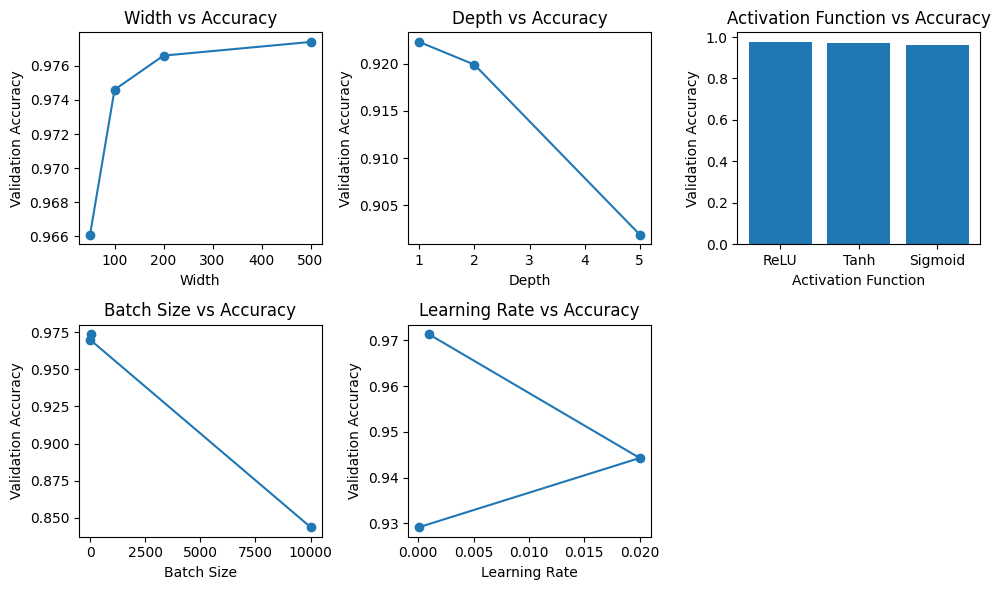

In [ ]:
#забыла в трейнинг код добавить визуализацию
import matplotlib.pyplot as plt

# Results data (you can extend it with your own results)
width_results = {
    50: 0.9661,
    100: 0.9746,
    200: 0.9766,
    500: 0.9774,
}
depth_results = {
    1: 0.9223,
    2: 0.9199,
    5: 0.9019,
}
activation_results = {
    'ReLU': 0.974,
    'Tanh': 0.9708,
    'Sigmoid': 0.9618,
}
batch_size_results = {
    10000: 0.8438,
    1: 0.9699,
    64: 0.9734,
}
lr_results = {
    0.0001: 0.9292,
    0.02: 0.9443,
    0.001: 0.9713,
}

# Plotting width vs accuracy
plt.figure(figsize=(10, 6))
plt.subplot(2, 3, 1)
plt.plot(list(width_results.keys()), list(width_results.values()), marker='o')
plt.title('Width vs Accuracy')
plt.xlabel('Width')
plt.ylabel('Validation Accuracy')

# Plotting depth vs accuracy
plt.subplot(2, 3, 2)
plt.plot(list(depth_results.keys()), list(depth_results.values()), marker='o')
plt.title('Depth vs Accuracy')
plt.xlabel('Depth')
plt.ylabel('Validation Accuracy')

# Plotting activation function vs accuracy
plt.subplot(2, 3, 3)
plt.bar(activation_results.keys(), activation_results.values())
plt.title('Activation Function vs Accuracy')
plt.xlabel('Activation Function')
plt.ylabel('Validation Accuracy')

# Plotting batch size vs accuracy
plt.subplot(2, 3, 4)
plt.plot(list(batch_size_results.keys()), list(batch_size_results.values()), marker='o')
plt.title('Batch Size vs Accuracy')
plt.xlabel('Batch Size')
plt.ylabel('Validation Accuracy')

# Plotting learning rate vs accuracy
plt.subplot(2, 3, 5)
plt.plot(list(lr_results.keys()), list(lr_results.values()), marker='o')
plt.title('Learning Rate vs Accuracy')
plt.xlabel('Learning Rate')
plt.ylabel('Validation Accuracy')

# Adjust layout and show plots
plt.tight_layout()
plt.show()


### 1. **How does the change in width affect the validation accuracy and training time?**
   - **Answer**: Increasing width improves validation accuracy (50: 96.61%, 500: 97.74%), but increases training time.

### 2. **How does increasing the number of layers impact accuracy and time?**
   - **Answer**: More layers decrease accuracy (1 layer: 92.23%, 5 layers: 90.19%) and increase training time.

### 3. **Which combination of activation functions performed better, and why?**
   - **Answer**: **ReLU** performed best (97.40% accuracy) due to faster convergence and better performance than Tanh and Sigmoid.

### 4. **How do different batch sizes affect convergence and accuracy?**
   - **Answer**: **Batch size 64** gives the best balance (97.34% accuracy), while batch sizes of 1 and 10000 lead to poor accuracy or very slow convergence.

### 5. **How did the learning rate impact training speed and accuracy?**
   - **Answer**: **Learning rate 0.001** gave the best performance (97.13% accuracy), balancing training speed and accuracy.

Early stopping at epoch 12
Test Accuracy: 0.9779
Training and Validation completed in 234.43 seconds
Final validation accuracy: 0.9779


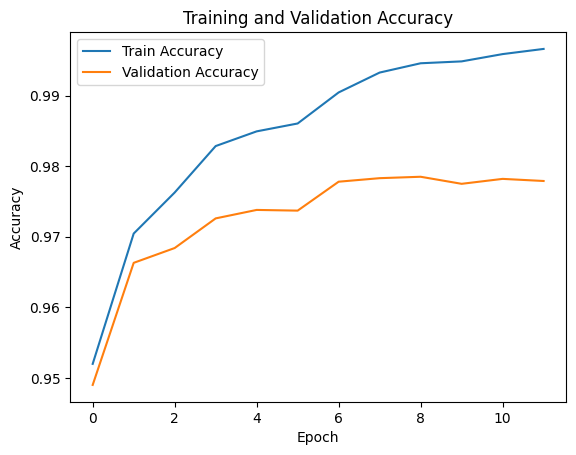

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import time
import matplotlib.pyplot as plt

# Датасет
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
val_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Модель (с инициализацией весов)
class SimpleNN(nn.Module):
    def __init__(self, input_size=28*28, hidden_size=100, output_size=10):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.init_weights()

    def init_weights(self):
        # Инициализация весов маленькими случайными значениями
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Обучение модели с ранней остановкой
def train_model(model, lr=0.001, batch_size=64, epochs=5, patience=3):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=1000, shuffle=False)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    best_val_acc = 0.0
    epochs_without_improvement = 0
    train_acc_list, val_acc_list = [], []

    start = time.time()
    for epoch in range(epochs):
        model.train()
        for X, y in train_loader:
            X, y = X.view(X.size(0), -1).to(device), y.to(device)
            optimizer.zero_grad()
            out = model(X)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

        # Получение точности на валидационном наборе
        train_acc = get_accuracy(train_loader, model, device)
        val_acc = get_accuracy(val_loader, model, device)
        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)

        # Ранняя остановка
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    total_time = time.time() - start
    return train_acc_list, val_acc_list, total_time

# Точность на датасете
def get_accuracy(loader, model, device):
    correct, total = 0, 0
    model.eval()
    with torch.no_grad():
        for X, y in loader:
            X, y = X.view(X.size(0), -1).to(device), y.to(device)
            out = model(X)
            pred = out.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    return correct / total

# Оценка на тестовой выборке
def evaluate_on_test(model, test_dataset, device):
    test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)
    test_acc = get_accuracy(test_loader, model, device)
    print(f"Test Accuracy: {test_acc:.4f}")
    return test_acc

# Основной блок
model = SimpleNN(input_size=28*28, hidden_size=100, output_size=10)
train_acc_list, val_acc_list, duration = train_model(model, epochs=15)

# Оценка на тестовом наборе
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
test_acc = evaluate_on_test(model, test_dataset, device)

# Печать результатов
print(f"Training and Validation completed in {duration:.2f} seconds")
print(f"Final validation accuracy: {val_acc_list[-1]:.4f}")

# Построение графиков
plt.plot(train_acc_list, label='Train Accuracy')
plt.plot(val_acc_list, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


Theoretical questions
**1)** Overfitting occurs when a model learns the training data too well, including noise and outliers, resulting in poor generalization to new data. To prevent overfitting on the MNIST dataset, techniques like dropout, early stopping, weight regularization and data augmentation can be applied to improve generalization.

**2)** Batch size influences the stability and speed of training—small batches provide noisy updates but better generalization, while large batches offer faster, smoother training but may overfit. The learning rate controls how quickly the model updates its weights; too high can cause divergence, too low can slow convergence or get stuck in local minima.